# Group Assignment 1: Edmunds Discussion Forum Analysis
<br /> Group Members: Domitille Chambon, Saiansh Raizada, Steven Hobson, Johann Thomas, Samuel D'Avila, Purva Tiwari

<br /><br />In this analysis, we are working with 11050 comments.
<br /><br />https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

## Task A

### Importing packages

In [70]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from sklearn.manifold import MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import re

#To ignore warning messages
import warnings
warnings.filterwarnings('ignore')

### Reading in forum and and brand to model csv

In [71]:
# Reading and cleaning brand map dataframe
brand_model_map = pd.read_csv('car models and brands (3).csv')

brand_model_map['Brand'] = brand_model_map['Brand'].astype('string')
brand_model_map['Model'] = brand_model_map['Model'].astype('string')

brand_model_map['Model'].apply(str.lower)
brand_model_map['Brand'].apply(str.lower)

0      acura
1      acura
2      acura
3      acura
4      acura
       ...  
525    volvo
526    volvo
527    volvo
528    volvo
529    volvo
Name: Brand, Length: 530, dtype: object

In [72]:
# Reading in scraped data
data = pd.read_csv('edmunds_forum.csv')

# Removes '/n' from start of each comment
data['comments'] = data['comments'].str[1:]

### Creating and Cleaning Corpus

In [73]:
# Function to remove punctuation
def punctuation_extermination(s):
    o = str.maketrans('', '', string.punctuation)
    return str(s).translate(o)

# Removing punctation from comments
data['comments'] = data['comments'].apply(punctuation_extermination)

In [74]:
def build_corpus(text_col):
    """To build a text corpus by stitching all the records together.Input the text column"""
    corpus = ""
    for sent in text_col:
        corpus += sent
    return corpus

In [75]:
#Building the corpus
corpus = build_corpus(data['comments'])

In [76]:
#Converting all the words into lowercase
corpus = corpus.lower()

In [77]:
#Splitting the entire corpus
corpus = corpus.split()

### Plotting 100 most common words

In [78]:
def plot_word_frequency(words, top_n=100):
    """Function to plot the word frequencies"""
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    tempDict = {"Labels": labels, "Count": counts}
    plt.figure(figsize=(15,5))
    plt.title("Most Frequent Words in the Corpus - Including STOPWORDS")
    plt.ylabel("Count")
    plt.xlabel("Word")
    plt.xticks(rotation=90)
    plot = sns.barplot(data= tempDict, x= "Labels", y= "Count")
    return plot

<AxesSubplot:title={'center':'Most Frequent Words in the Corpus - Including STOPWORDS'}, xlabel='Word', ylabel='Count'>

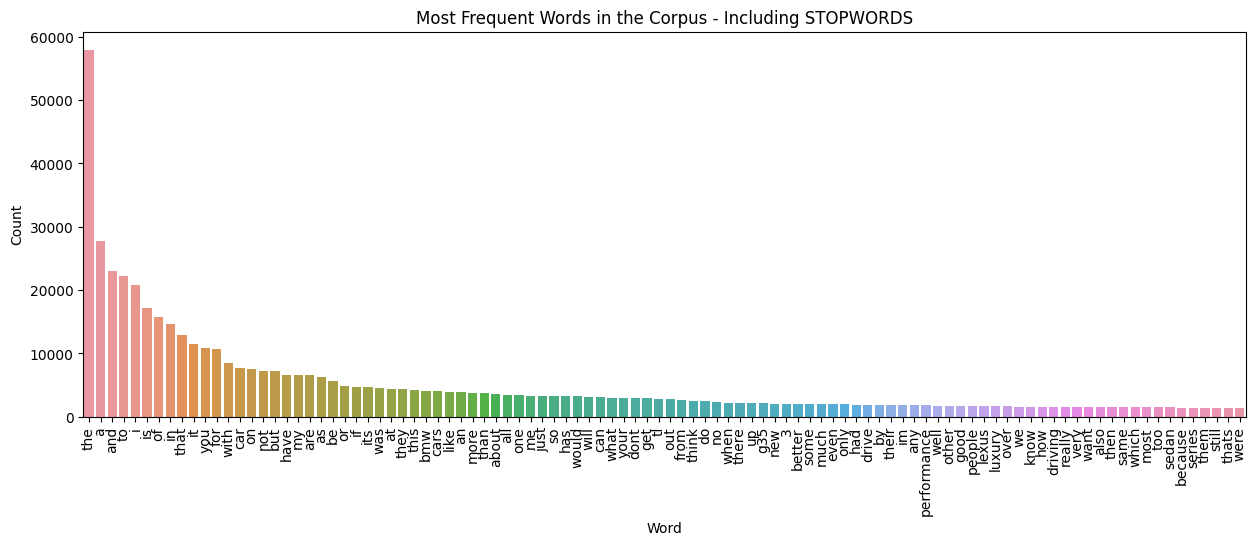

In [79]:
plot_word_frequency(corpus)

### Zipf's Law

In [80]:
freq = FreqDist(corpus)
last_rank = 100

words = [element[0] for element in freq.most_common(last_rank)] # words (x axis)
counts = [element[1] for element in freq.most_common(last_rank)] # freqs (y axis)
l = list(range(1,101))

In [81]:
# Creating our test frequencies and holds them in memory

top_frequency = counts[0]
zipf_list = []
y_freq = []
ranks = []
theta = 1
# print(counts[:10])
for idx, freq in enumerate(counts, start=1):
    # Calculating Zipf's ideal case
    zipf_list.append(top_frequency * (1/idx))
    # Calculating Zipf's for our data
    y_freq.append(theta*np.log(freq/(last_rank*counts[-1])))
    # Mapping ranks 
    ranks.append(idx)

zipf_list = np.log(zipf_list)
ranks = np.log(ranks)


In [82]:
from sklearn.linear_model import LinearRegression

y = ranks.reshape((-1, 1))
x = np.array(y_freq).reshape((-1, 1))

X = pd.DataFrame(x, columns=['X1'])
y = pd.DataFrame(y, columns=['Y'])        


lr = LinearRegression().fit(x, y)

print(f"b0: {lr.intercept_}")
print(f"b1: {lr.coef_}")

b0: [-0.56687407]
b1: [[-1.13593992]]


In [83]:
N = len(x)
p = 1 + 1  # plus one because LinearRegression adds an intercept term

X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = x

In [84]:
import statsmodels.api as sm
ols = sm.OLS(y.values, X_with_intercept)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8694.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):           1.65e-97
Time:                        20:08:23   Log-Likelihood:                 90.907
No. Observations:                 100   AIC:                            -177.8
Df Residuals:                      98   BIC:                            -172.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5669      0.046    -12.283      0.000      -0.658      -0.475
x1            -1.1359      0.012    -93.242      0.000      -1.160      -1.112
==============================================================================
Omnibus:                       60.582   Durbin-Watson:                   0.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.238
Skew:                          -1.900   Prob(JB):                     1.18e-72
Kurtosis:                      11.066   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

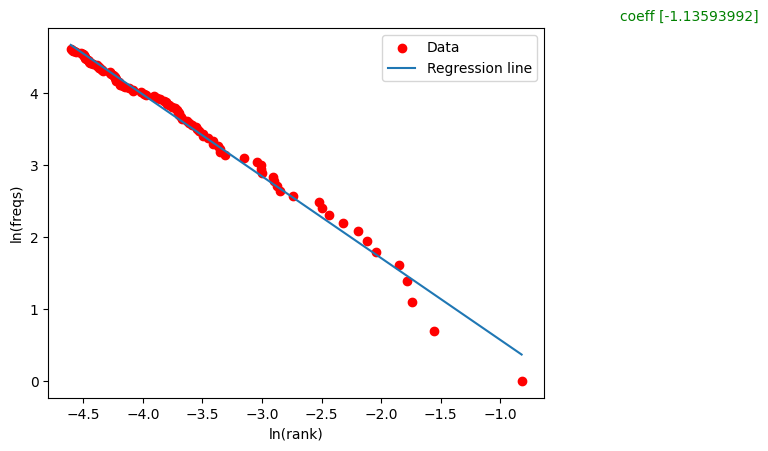

In [85]:
plt.scatter(x,y,label='Data',color='red')
plt.plot(x,lr.predict(x),label='Regression line')
plt.xlabel("ln(rank)")
plt.ylabel("ln(freqs)")
plt.text(x=0,y=5,s=r"coeff "+str(lr.coef_[0]), fontsize=10, color="g")
plt.legend()

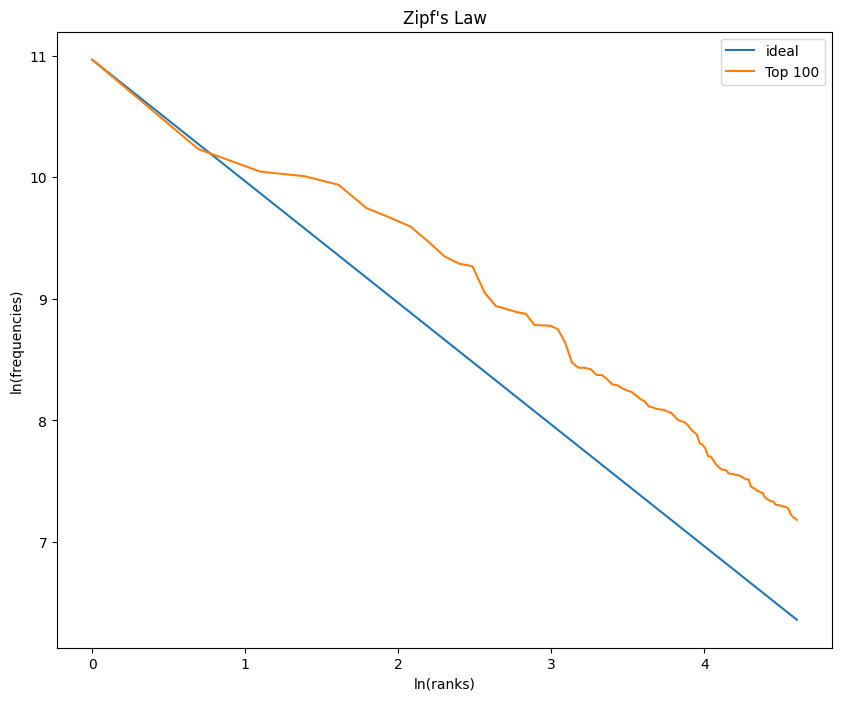

In [86]:
# Creates Zipf Law's plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, title="Zipf's Law")

difference = zipf_list[0] - y_freq[0]

y_freq = [x+difference for x in y_freq]

ax.plot(ranks, zipf_list, label='ideal') # Ideal Case
ax.plot(ranks, y_freq, label='Top 100', ) # Our data
plt.xlabel('ln(ranks)')
plt.ylabel('ln(frequencies)')
plt.legend(loc='upper right')
plt.show()

## Task B

### Finding top 10 brands from frequency

In [87]:
# Creates string of all comments
corpus = ""
for l in data['comments']:
    l = str(l).lower()
    corpus += l

# Removing stopwords from new string
corpus = corpus.split()
corpus_without_stop = [word for word in corpus if word not in stopwords.words("english")]

In [88]:
# Creating dictionary of models and assoociated brands
set(brand_model_map["Model"])
modellookup = brand_model_map.set_index("Model").to_dict()["Brand"]

In [89]:
# Function to switch car models with associated brands
def mbswitch(x):
    t = x.split()
    for word in t:
        if word in modellookup:
            x = x.replace(word, modellookup[word])
    return x

# Switching models to brands in comments
corpus_without_stop = [x.lower() for x in corpus_without_stop]
corpus_swapped = [mbswitch(x) for x in corpus_without_stop]
data['comments'] = data['comments'].apply(lambda i: i.lower())
data['comments'] = data['comments'].apply(lambda i: (mbswitch(i)))

In [90]:
# Creates a list of brands
brandlist = [brand_model_map["Brand"]]

In [91]:
# Frequency of words in comments
freq_dict = {}
for word in corpus_swapped:
    if word not in freq_dict.keys():
        freq_dict[word] = 1
    elif word in freq_dict.keys():
        freq_dict[word] += 1
    else:
        print('error')

In [92]:
# list of brands
brand_strings = (brand_model_map['Brand'].values)

# Frequency of each brand
brand_strings = set(brand_strings)
car_dict = {}
for package in brand_strings:
    if package in freq_dict.keys():
        car_dict[package] = freq_dict[package]

In [93]:
# Removes cars that return 0 freq value and other words that don't fit what we're looking for
removeList = ['car', 'problem', 'seat', 'sedan', 'volkwagen']
for key in car_dict.keys():
    if car_dict[key] == 0:
        removeList.append(key)

for car in removeList:
    del car_dict[car]

car_dict

{'honda': 1271,
 'mercury': 19,
 'infiniti': 1046,
 'subaru': 476,
 'cadillac': 420,
 'dodge': 170,
 'bmw': 6527,
 'chevrolet': 279,
 'kia': 39,
 'suzuki': 30,
 'toyota': 961,
 'mitsubishi': 52,
 'chrysler': 153,
 'hyndai kia': 2,
 'acura': 1542,
 'mercedes-benz': 384,
 'nissan': 797,
 'kia.': 1,
 'buick': 194,
 'volkswagen': 450,
 'mercedes': 87,
 'lincoln': 429,
 'pontiac': 177,
 'hyundai': 357,
 'ford': 432,
 'volvo': 649,
 'audi': 2045,
 'mazda': 267,
 'saturn': 43}

In [94]:
# Sort from highest freq to lowest and pull top 10 in dictionary
top10BrandsDict = dict(sorted(car_dict.items(), key=lambda item: item[1], reverse= True)[:10])

# Top 10 brands
top10Brands = list(top10BrandsDict.keys())

## Task C

### Calculating lift ratios for top 10 brands

In [95]:
lift_dict = pd.DataFrame(index= top10Brands, columns= top10Brands)
total_shape = data.shape[0]
for i in range(len(top10Brands)):
    for j in range(len(top10Brands)):
        brand_1 = top10Brands[i]
        brand_2 = top10Brands[j]
        count_1 = 0
        count_2 = 0
        count_3 = 0
        
        for txt in data.comments.values:
            if brand_1 in txt and brand_2 in txt:
                count_3 = count_3 + 1
            elif brand_1 in txt and brand_2 not in txt:
                count_1 = count_1 + 1 
            elif brand_1 not in txt and brand_2 in txt:
                count_2 = count_2 + 1
        
        if(brand_1==brand_2):
            lift_dict[brand_1][brand_2] = 0

        else:
            pa = count_1/total_shape
            pb = count_2/total_shape
            pab = count_3/total_shape
            ans = (pa*pb)/pab
            
            lift_dict[brand_1][brand_2] = round(1/ans,3)

In [96]:
lift_dict.apply(pd.to_numeric).style.background_gradient(axis=0,cmap='Blues')

,bmw,audi,acura,honda,infiniti,toyota,nissan,volvo,subaru,volkswagen
bmw,0.000000,4.217000,3.112000,2.208000,4.964000,2.850000,1.881000,2.857000,2.064000,2.762000
audi,4.217000,0.000000,3.663000,2.092000,4.060000,2.003000,1.464000,6.130000,2.622000,6.884000
acura,3.112000,3.663000,0.000000,5.661000,7.816000,2.760000,3.808000,4.182000,3.040000,2.526000
honda,2.208000,2.092000,5.661000,0.000000,2.147000,8.029000,6.337000,3.135000,2.408000,3.499000
infiniti,4.964000,4.060000,7.816000,2.147000,0.000000,2.310000,5.106000,3.049000,2.184000,2.333000
toyota,2.850000,2.003000,2.760000,8.029000,2.310000,0.000000,6.339000,3.109000,1.841000,2.340000
nissan,1.881000,1.464000,3.808000,6.337000,5.106000,6.339000,0.000000,2.910000,2.601000,3.559000
volvo,2.857000,6.130000,4.182000,3.135000,3.049000,3.109000,2.910000,0.000000,5.312000,4.077000
subaru,2.064000,2.622000,3.040000,2.408000,2.184000,1.841000,2.601000,5.312000,0.000000,3.862000
volkswagen,2.762000,6.884000,2.526000,3.499000,2.333000,2.340000,3.559000,4.077000,3.862000,0.000000


## Task D

### Multi-dimensional Scaling map

In [97]:
mdslifts = lift_dict
mdslifts.reset_index(drop=True, inplace=True)
mds = MDS(random_state=0)
mdslifts = mds.fit_transform(mdslifts)
mdslifts

array([[ 0.17032106,  0.72093278],
       [ 3.32362636, -5.702624  ],
       [ 2.17736704,  5.85649958],
       [-3.98796643, -6.38343955],
       [-6.2983281 , -1.88169982],
       [ 5.35465243,  4.17700652],
       [ 5.82494468, -1.31963403],
       [-4.61846294,  2.26301726],
       [ 0.74449119, -2.39926924],
       [-2.69064528,  4.6692105 ]])

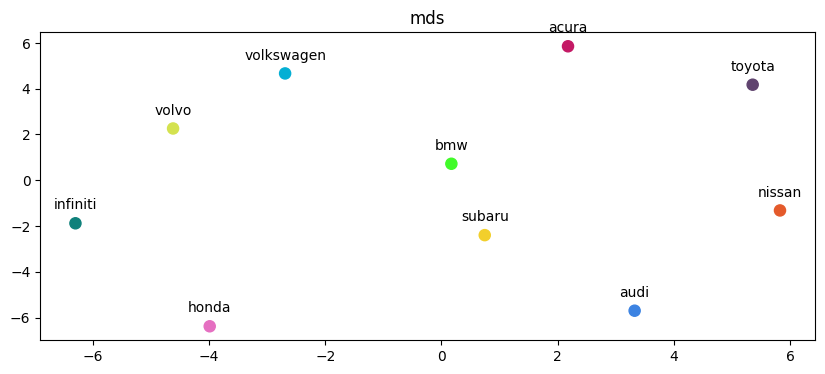

In [98]:
colors = ['#41FB29', '#3C83E2', '#C41965', '#E56FC1', '#0F817B', '#60446F', '#E45A2B', '#D4E24F', '#F2CF2B', '#04AFD4']

size = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64] ##41FB29
fig = plt.figure(2, (10,4))
plt.scatter(mdslifts[:,0], mdslifts[:,1], s=size, c=colors)
count = 0
for x, y in zip(mdslifts[:,0], mdslifts[:,1]):
    label = "{0}".format(top10Brands[count])
    count += 1
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha=('center') # horizontal alignment
    )
plt.title('mds')
plt.show()

## Task E

### Insights for the client

Upon initial analysis, we discovered interesting insights about the affordable Japanese brands: Honda, Toyota, Subaru, and Nissan. First, Honda and Toyota scored a lift value of 8.03, which is expected due to their similarity in nature. Subaru specifically was surprising because it was very dissimilar to Honda and Toyota with lift values of 2.4 and 1.8, respectively. People who are interested in these brands are more focused on functionality, safety, and reliability over style and luxury. So, we would expect all three to be somewhat similar; however, as mentioned above, Subaru is very dissimilar in this analysis. Subaru is a much smaller company compared to Honda and Toyota specifically; therefore, despite not being similar to them, they could grow their company more if they stole consumers from Honda and Toyota. Due to the size difference, Subaru's strategy may be to corner their own section of the market, so they could increase their perceived uniqueness compared to other brands.
<br /><br />Looking specifically at the luxury brands, we expected to see higher lifts for several of the brands. Acura and Infiniti had a score of 7.8, which is relatively high. And, we expected to see similar lift values for the other luxury brands. BMW and Audi was the most surprising difference. We expected these two brands to be very similar with each other due to both being German luxury brands; however, they only scored a lift value of 4.2. Comparatively, this was lower than other brand associations we saw, such as Honda and Toyota. Acura and Infiniti are both Japanese luxury brands, scoring a 7.8 lift value; therefore, we expected similar results for BMW and Audi. Given the highly competitive luxury car market, the fact that these two luxury brands are not similar could suggest that their marketing strategies have resulted in the brands being differentiable.
<br /><br />Another relationship we looked at was parent brands and their subsidiary luxury brands. We looked at Infiniti & Nissan, Acura & Honda, and Audi & Volkswagen. The lifts were 5.1, 5.6, and 6.8, respectively. This suggests a relatively high association between the parent company and their luxury brand, which makes sense given they are a part of the same company. However, they created these luxury brands to target a different customer base. So, perhaps, they should continue to increase the dissimilarities to further differentiate their luxury and affordable product lines to appeal more strongly to the consumers within those respective segments.

## Task F

### 5 most frequently mentioned attributes

In [99]:
attr = ['performance', 'luxury', 'expensive', 'safety', 'smooth'] 

### Lift analysis of 5 attributes with brands

In [100]:
# Calculating lift values
attr_lifts= pd.DataFrame(index=attr, columns=top10Brands)
total_shape = data.shape[0]
for i in range(len(top10Brands)):
    for j in range(len(attr)):
        brand_1 = top10Brands[i]
        brand_2 = attr[j]
        count_1 = 0
        count_2 = 0
        count_3 = 0
        
        for txt in data.comments.values:
            if brand_1 in txt and brand_2 in txt:
                count_3 = count_3 + 1
            elif brand_1 in txt and brand_2 not in txt:
                count_1 = count_1 + 1 
            elif brand_1 not in txt and brand_2 in txt:
                count_2 = count_2 + 1
        
        if(brand_1==brand_2):
            ans=0

        pa = count_1/total_shape
        pb = count_2/total_shape
        pab = count_3/total_shape

        if(pab!=0):
            ans = (pa*pb)/pab
        else:
            ans = 0

        if(ans!=0):
            attr_lifts[brand_1][brand_2] = round(1/ans,3)
        else:
            attr_lifts[brand_1][brand_2] = 0

In [101]:
#creates lifts with shading
attr_lifts.apply(pd.to_numeric).style.background_gradient(axis=0,cmap='Blues')

,bmw,audi,acura,honda,infiniti,toyota,nissan,volvo,subaru,volkswagen
performance,3.588000,2.075000,2.248000,2.163000,2.263000,2.435000,1.868000,2.184000,2.630000,1.578000
luxury,3.130000,2.590000,3.202000,2.674000,2.618000,3.958000,1.767000,4.331000,4.323000,2.926000
expensive,3.512000,2.552000,1.666000,1.887000,2.066000,2.414000,1.741000,2.426000,0.839000,1.216000
safety,1.510000,1.695000,1.811000,1.882000,0.673000,2.998000,3.658000,9.757000,1.232000,1.964000
smooth,4.078000,2.345000,2.137000,2.353000,2.026000,2.116000,2.801000,2.033000,3.511000,0.905000


## Task G

### Advice for the client

When analyzing the attribute association with these various brands, we would like to offer three pieces of advice. First, we discovered in our analysis that Subaru and safety are not closely associated. This discovery came as a shock considering Subaru's marketing strategy to be perceived as a family brand. Subaru's advertisements often show families riding together in a car and their slogan is "Love." However, their association with safety based on our lift analysis is very low with a score of 1.23. Our advice would be Subaru should either focus more on safety in future products or they emphasize safety more in their future marketing campaigns alongside family.
<br /><br />Our second advice is derived from the high association between Toyota and the attribute "expensive". From our lift analysis, Toyota and expensive had a lift value of 2.4, which was higher than most of the other affordable car brands such as Honda and Nissan. It seems Toyota is being perceived on the more expensive end of the affordable brands. Our advice to Toyota would be to develop different car models that capture a greater segment of the lower cost car market.
<br /><br />Our third piece of advice would be for Audi to either market their smooth driving more or develop car models that give a smoother feel while driving as compared to BMW. We arrived to this conclusion due to our lift analysis, which showed BMW was far more associated with smooth driving in comparison to Audi. BMW and smooth has a lift value of 4.07, whereas Audi has a value of 2.35. With both companies being German luxury brands, they compete in the same market. Therefore, it would be logical for Audi to increase their perceived reputation for smoother driving cars in order to more effectively compete with BMW.

## Task H

### Aspiration

In [102]:
attr_aspi = [ 'aspire to', 'wish to', 'desire to', 'yearn to', 'crave to', 'one day', 'my dream', 'saving up', 'lust to', 'covet', 'thirsty']
brandList = list(car_dict.keys())

aspi_attr_lifts= pd.DataFrame(index=attr_aspi, columns=brandList)
total_shape = data.shape[0]
for i in range(len(brandList)):
    for j in range(len(attr_aspi)):
        brand_1 = brandList[i]
        brand_2 = attr_aspi[j]
        count_1 = 0
        count_2 = 0
        count_3 = 0
        
        for txt in data.comments.values:
            if brand_1 in txt and brand_2 in txt:
                count_3 = count_3 + 1
            elif brand_1 in txt and brand_2 not in txt:
                count_1 = count_1 + 1 
            elif brand_1 not in txt and brand_2 in txt:
                count_2 = count_2 + 1
        
        if(brand_1==brand_2):
            ans=0

        pa = count_1/total_shape
        pb = count_2/total_shape
        pab = count_3/total_shape
        
        if(pab!=0):
            ans = (pa*pb)/pab
        else:
            ans = 0
        
        if(ans!=0):
            aspi_attr_lifts[brand_1][brand_2] = round(1/ans,3)
        else:
            aspi_attr_lifts[brand_1][brand_2] = 0


In [103]:
aspi_attr_lifts.apply(pd.to_numeric).style.background_gradient(axis=0,cmap='Blues')

,honda,mercury,infiniti,subaru,cadillac,dodge,bmw,chevrolet,kia,suzuki,toyota,mitsubishi,chrysler,hyndai kia,acura,mercedes-benz,nissan,kia.,buick,volkswagen,mercedes,lincoln,pontiac,hyundai,ford,volvo,audi,mazda,saturn
aspire to,1.063000,0,3.877000,10.798000,0.000000,26.102000,10.695000,0.000000,0,0,1.275000,0.000000,0,0,2.941000,0.000000,1.834000,0,0.000000,0.000000,0.000000,0.000000,0.000000,8.773000,0.000000,2.509000,5.750000,12.849000,0
wish to,4.263000,0,2.582000,0.000000,2.518000,0.000000,1.601000,4.525000,0,0,7.684000,0.000000,0,0,0.890000,19.523000,2.001000,0,5.773000,0.000000,13.778000,4.100000,0.000000,4.368000,0.000000,0.000000,0.000000,0.000000,0
desire to,2.328000,0,0.516000,1.430000,0.000000,11.349000,2.354000,0.000000,0,0,1.277000,10.045000,0,0,1.279000,0.000000,0.880000,0,0.000000,1.478000,0.000000,0.000000,7.194000,0.000000,3.849000,0.000000,0.765000,3.555000,0
yearn to,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
crave to,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
one day,2.561000,0,2.588000,0.000000,0.000000,0.000000,3.795000,0.000000,0,0,2.192000,0.000000,0,0,1.401000,1.680000,0.000000,0,0.000000,1.607000,1.189000,0.000000,0.000000,2.089000,0.915000,0.000000,3.069000,0.000000,0
my dream,0.000000,0,2.579000,0.000000,0.000000,0.000000,3.202000,0.000000,0,0,7.663000,0.000000,0,0,1.957000,0.000000,0.000000,0,0.000000,7.391000,0.000000,0.000000,0.000000,0.000000,0.000000,6.022000,0.000000,0.000000,0
saving up,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
lust to,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
covet,0.000000,0,0.000000,0.000000,0.000000,0.000000,3.200000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,38.636000,0.000000,0,0.000000,0.000000,27.351000,0.000000,0.000000,48.043000,0.000000,0.000000,0.000000,0.000000,0


In [104]:
aspi_attr_lifts.sum(axis=0)

honda            10.215
mercury               0
infiniti         12.142
subaru           12.228
cadillac          16.47
dodge            37.451
bmw              26.448
chevrolet          9.05
kia                   0
suzuki                0
toyota           20.091
mitsubishi       10.045
chrysler              0
hyndai kia            0
acura             8.468
mercedes-benz    59.839
nissan            4.715
kia.                  0
buick            11.546
volkswagen       10.476
mercedes         42.318
lincoln             4.1
pontiac           7.194
hyundai          67.641
ford              4.764
volvo             8.531
audi             12.646
mazda            16.404
saturn                0
dtype: object

### Aspiration Analysis

We determined that Mercedes-Benz is the most aspirational brand based upon our analysis. We arrived to this conclusion by calculating lift values between brands and a list of aspirational words and phrases. We then proceeded to sum the lift values for each brand to determine which ones had higher total associations to aspiration across all of the aspirational phrases. Looking at the matrix, it may not be apparent; however, Mercedes was by far the most aspirational brand because there were two columns, Mercedes and Mercedes-Benz. We summed these column totals to determine the total lift value association for the Mercedes brand was over 101. All the aspirational words and phrases were relatively evenly distributed, so there was no need for us to assign weights to the words and phrases.
<br /><br />The business implications for Mercedes is they continue to uphold their status as a brand of cars that people desire to own. This is a very advantageous position to be in as a company and as a brand because it shows that there is a steady demand for their products. Having a high brand equity means customers are willing to pay more for their products than the direct materials in the car. The brand name allows Mercedes to charge a premium for their cars than another company who may be selling the same cars. The other point about aspirational means that customers can't make the purchase at the moment but desires it, so it secures future demand. Because they're aspirational, younger people who cannot buy their products now will in the future. Overall, Mercedes position as an aspirational brand gives them a competitive advantage in terms of brand equity.